# LSTM Time Series

Method:
* Uses the historical dataset to learn, and then the a subset of the newer dataset to make prediction. This allows us to actually compare the predictions to what the values really were. The subset range can be modified at will.


Findings:
* As opposed to statistical time series LSTM does well on daily basis, but fails on monthly/weekly data. Likely because it needs lots of data to learn anything. Can be an interesting point to make, that LSTM is good to model daily data and statistical time series is better for monthly/weekly.
* Does really well compared to the standard ML approaches, however, accuracy not the best for all pollutants (try for more epochs maybe?)

Graph info:
* Graph #1 = predicted values vs actual values in the new 'live' dataset
* Graph #2 = historical data with the predictions appended at the end
* Graph #3 = historical data + new values from the 'live' dataset merged together, along with predicted values on top for comparison (this one needs updating as the predictions should overlap the new data at the end of axis, not at the start)

Code adapted from: https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn import linear_model

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

%matplotlib inline

Using TensorFlow backend.
/Users/damian/opt/anaconda3/envs/RLP2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/damian/opt/anaconda3/envs/RLP2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/damian/opt/anaconda3/envs/RLP2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/dami

In [2]:
df = pd.read_csv('data/BathHistoricalAirSensorData.csv')

# Clean so the data is the same as EDA

In [3]:
# drop irrelevant columns
df = df.drop(['sensor_location_name', 'id', 'sensor_location_slug', 'sensor_location'], axis=1)

# rename columns
df = df.rename(columns={'nox'   : 'nitrogen_oxides (No2 + NO) ppb',
                        'no'    : 'nitrogen_monoxide (NO) ppb',
                        'no2'   : 'nitrogen_dioxide (No2) ppb',
                        'co'    : 'carbon_monoxide (CO) ppm',
                        'pm10'  : 'aerosol_particles (pm10) µg/m3',
                        'o3'    : 'ozone (o3) ppb'})


df = df.dropna(subset=['nitrogen_oxides (No2 + NO) ppb'])

df = df.drop(['ozone (o3) ppb'], axis=1)

pollutants = ['nitrogen_monoxide (NO) ppb',
              'nitrogen_dioxide (No2) ppb',
             'carbon_monoxide (CO) ppm',
             'aerosol_particles (pm10) µg/m3']

# Set index as time
df['datetime'] = pd.to_datetime(df.datetime)
df = df.set_index('datetime')
df = df.sort_index()
#df = df.resample('W-MON').mean()

for p in pollutants:
    if df[p].isna().sum() > 0:
        df[p].interpolate(method='time', inplace=True)
        
df = df.dropna(subset=['aerosol_particles (pm10) µg/m3'])

df = df.drop(['nitrogen_oxides (No2 + NO) ppb'], axis=1)
        
print('\n* Null Values % of data after cleanup *')       
print(df.isna().sum()/len(df), '\n')
print('\n* Shape *')
print(df.shape[0])


* Null Values % of data after cleanup *
nitrogen_monoxide (NO) ppb        0.0
nitrogen_dioxide (No2) ppb        0.0
carbon_monoxide (CO) ppm          0.0
aerosol_particles (pm10) µg/m3    0.0
dtype: float64 


* Shape *
63896


# Clean the newer (not historical) dataset

In [4]:
df_new = pd.read_csv('data/BathAirSensorData.csv')

# drop irrelevant columns
df_new = df_new.drop(['sensor_location_name', 'id', 'sensor_location_slug', 'sensor_location'], axis=1)

# rename columns
df_new = df_new.rename(columns={'nox'   : 'nitrogen_oxides (No2 + NO) ppb',
                        'no'    : 'nitrogen_monoxide (NO) ppb',
                        'no2'   : 'nitrogen_dioxide (No2) ppb',
                        'co'    : 'carbon_monoxide (CO) ppm',
                        'pm10'  : 'aerosol_particles (pm10) µg/m3',
                        'o3'    : 'ozone (o3) ppb'})


df_new = df_new.dropna(subset=['nitrogen_oxides (No2 + NO) ppb'])

df_new = df_new.drop(['ozone (o3) ppb'], axis=1)

pollutants = ['nitrogen_monoxide (NO) ppb',
              'nitrogen_dioxide (No2) ppb',
             'carbon_monoxide (CO) ppm',
             'aerosol_particles (pm10) µg/m3']

# Set index as time
df_new['datetime'] = pd.to_datetime(df_new.datetime)
df_new = df_new.set_index('datetime')
df_new = df_new.sort_index()
#df_new = df_new.resample('W-MON').mean()

for p in pollutants:
    if df_new[p].isna().sum() > 0:
        df_new[p].interpolate(method='time', inplace=True)
        
df_new = df_new.dropna(subset=['aerosol_particles (pm10) µg/m3'])

df_new = df_new.drop(['nitrogen_oxides (No2 + NO) ppb'], axis=1)
        
print('\n* Null Values % of data after cleanup *')       
print(df_new.isna().sum()/len(df_new), '\n')
print('\n* Shape *')
print(df_new.shape[0])

# Selecting range to which the model will try and predict
df_new = df_new.loc['2014-07-08 17:00:00+00:00 ':'2015-01-01 00:00:00+00:00 ']
print('\n* Shape of the selected range *')
print(df_new.shape[0])


* Null Values % of data after cleanup *
nitrogen_monoxide (NO) ppb        0.0
nitrogen_dioxide (No2) ppb        0.0
carbon_monoxide (CO) ppm          0.0
aerosol_particles (pm10) µg/m3    0.0
dtype: float64 


* Shape *
94071

* Shape of the selected range *
10212


# LSTM Model

In [5]:
def lstm(x,y,epochs):
    regressor = Sequential()
    
    # lstm
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))

    # output layer
    regressor.add(Dense(units = 1))
    
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # fit
    regressor.fit(x, y, epochs = epochs, batch_size = 32, verbose=0)
    
    return regressor

# Training

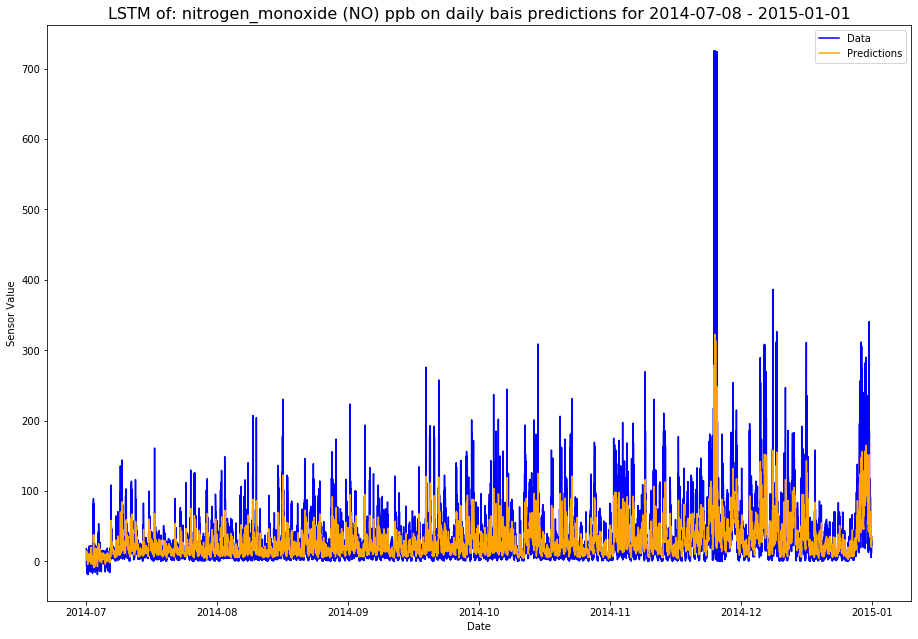

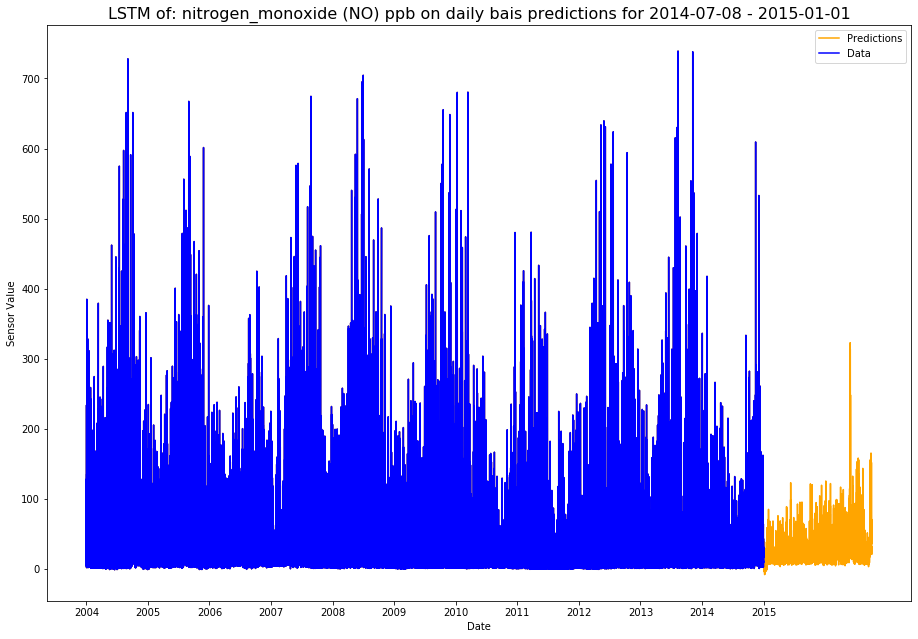

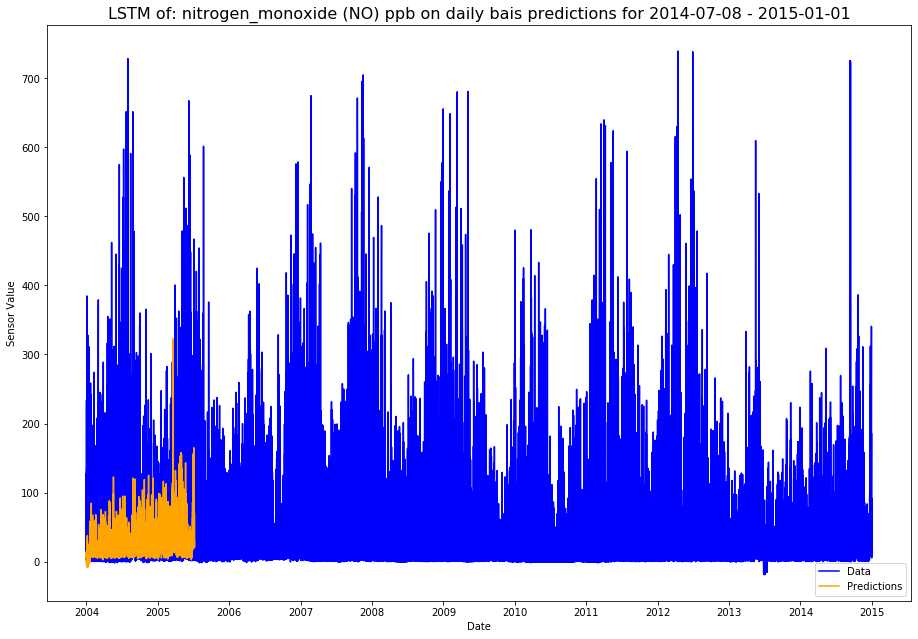

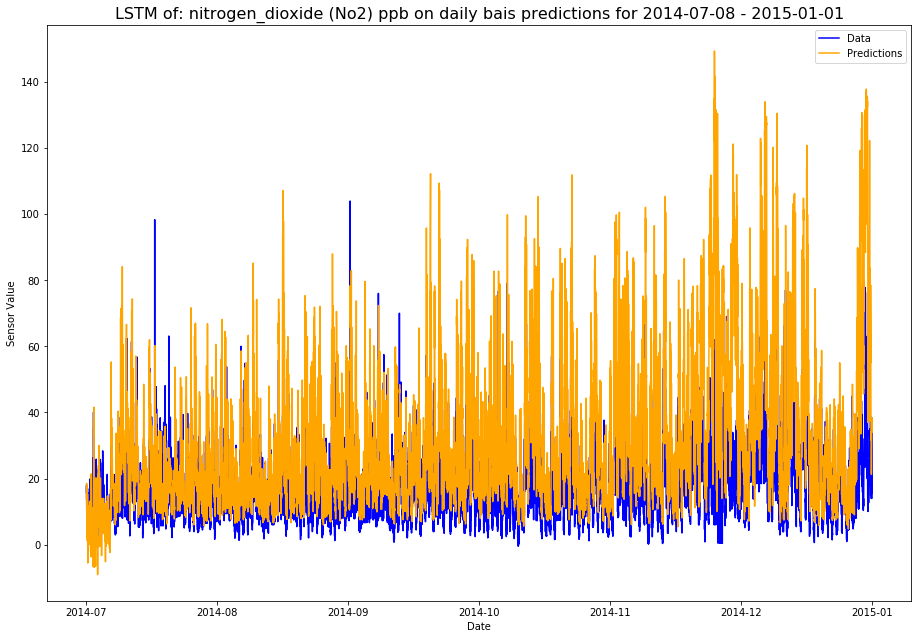

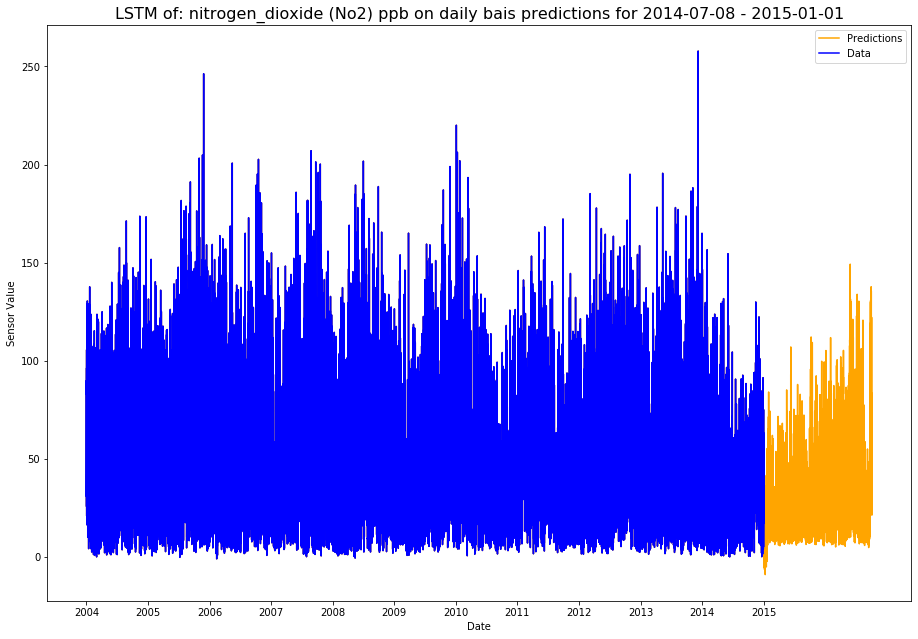

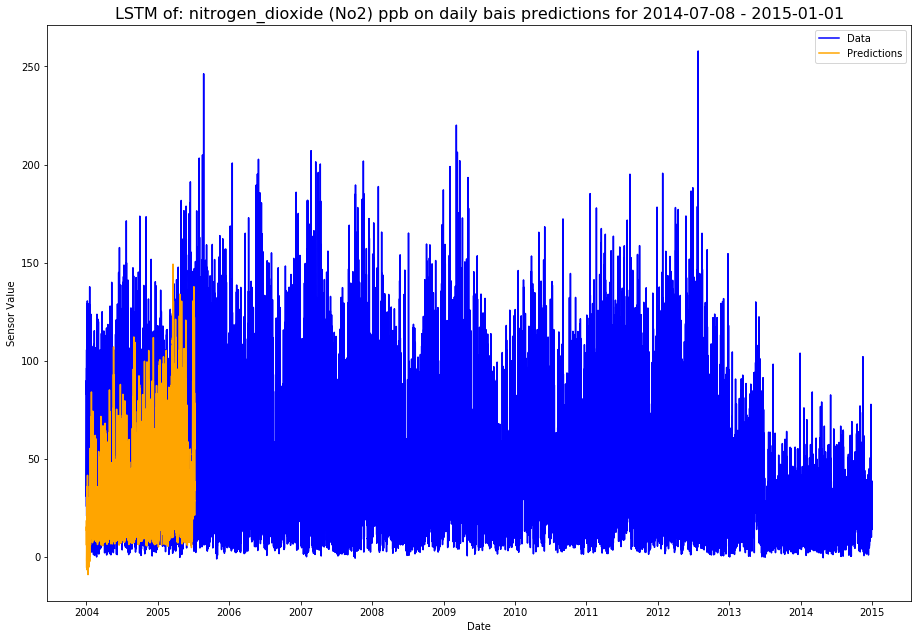

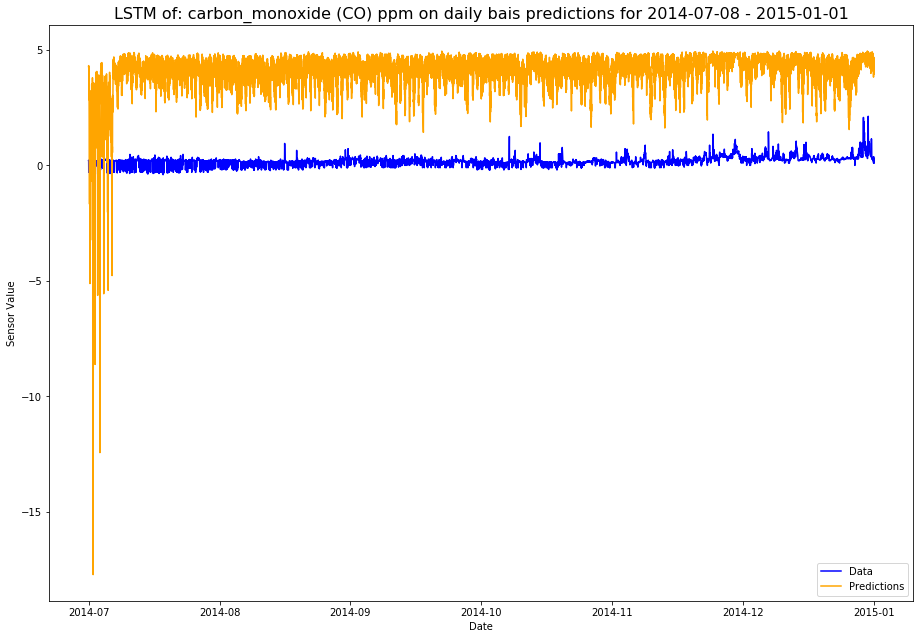

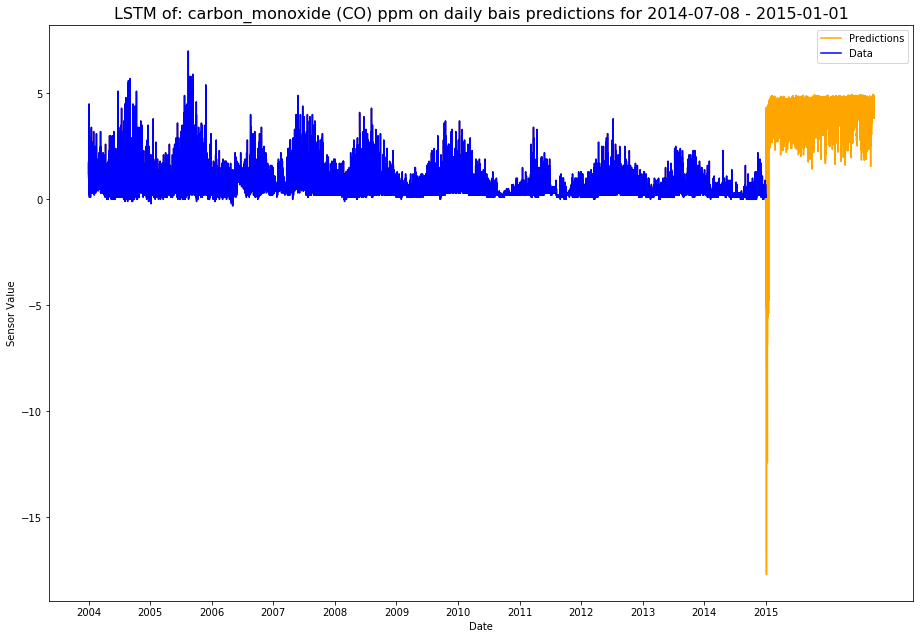

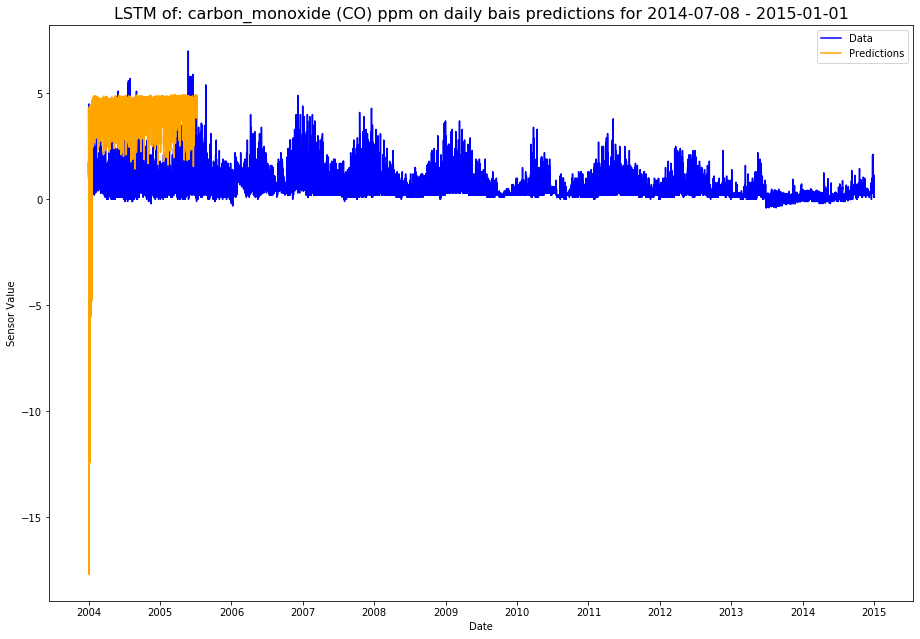

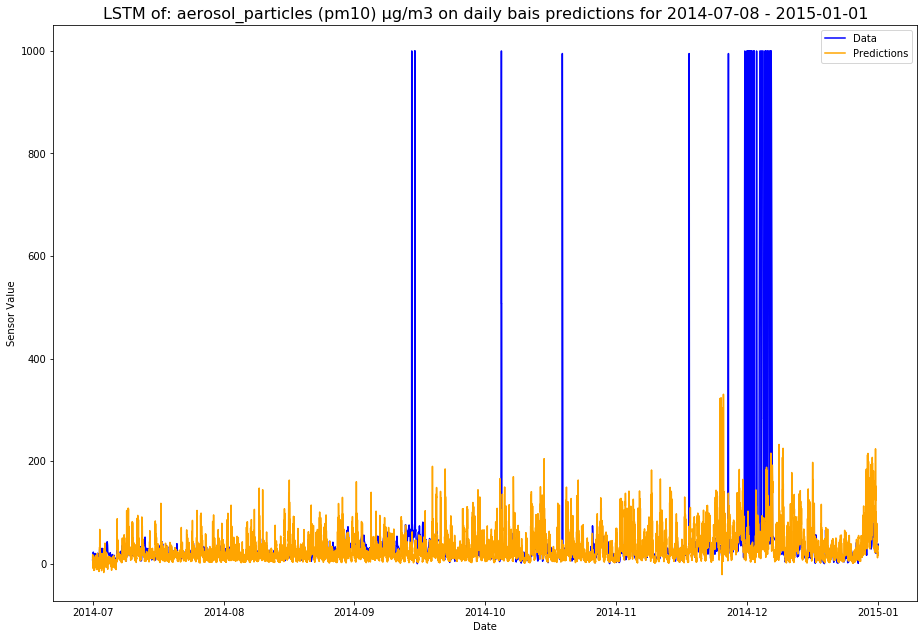

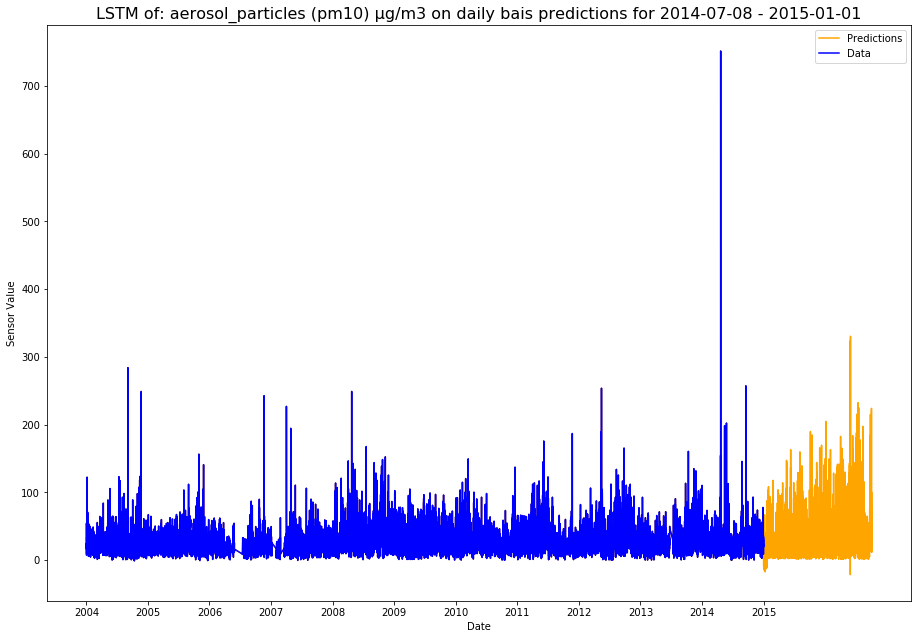

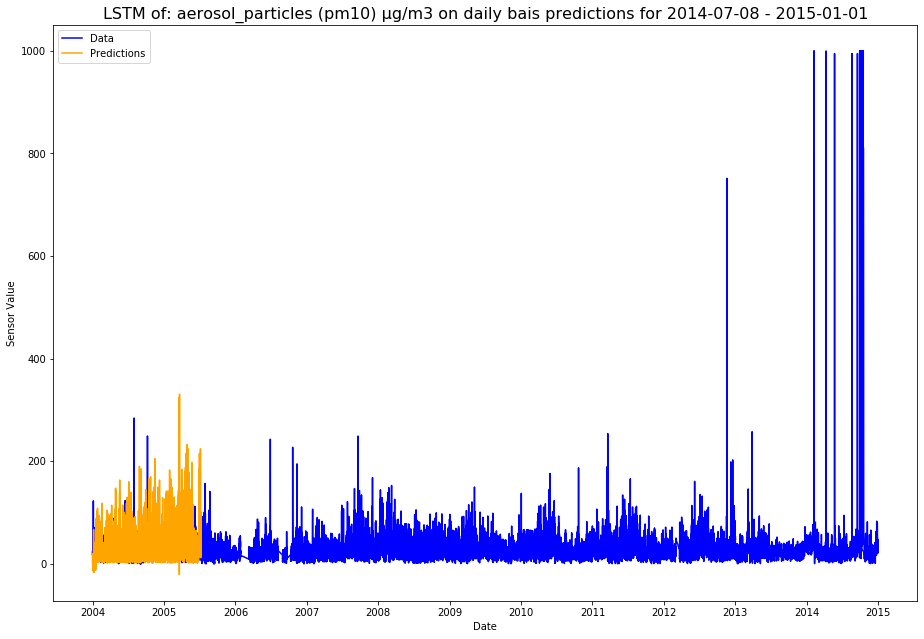

In [6]:
def plot(data, preds, part, invert):
        
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    
    if(part == False):
        labels = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]   

    else:
        labels = ['2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01']         

    if(invert == False):
        ax.plot(data, label='Data', color='blue')            
        ax.plot(preds, label='Predictions', color='orange')      
    else:
        ax.plot(preds, label='Predictions', color='orange')
        ax.plot(data, label='Data', color='blue')  
  
    ax.set_xlabel('Date')
    ax.set_ylabel('Sensor Value')    
    ax.set_title(('LSTM of: {} on daily bais predictions for {}'.format(pollutants[pollutant], '2014-07-08 - 2015-01-01')), size=16)  
    ax.set_xticks(np.linspace(0,(data.shape[0]),len(labels)))
        
    ax.set_xticklabels(labels)
    plt.legend()
    plt.show()        



pollutants = ['nitrogen_monoxide (NO) ppb', 'nitrogen_dioxide (No2) ppb', 
              'carbon_monoxide (CO) ppm', 'aerosol_particles (pm10) µg/m3']

# Train
for pollutant in [0,1,2,3]:
    
    # Select column with the right pollutant
    if pollutant != 3:
        training_set = df.iloc[:, pollutant:pollutant+1].values  
        real_vals = df_new.iloc[:, pollutant:pollutant+1].values   
    else: 
        training_set = df.iloc[:,3:].values 
        real_vals = df_new.iloc[:, 3:].values        

    X_train = []
    y_train = []

    # Feature Scaling
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    # Sequences of 60 for the training sets
    for i in range(60, training_set_scaled.shape[0]):
        X_train.append(training_set_scaled[i-60:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Fit model
    regressor = lstm(X_train, y_train, epochs=3)

    dataset_total = pd.concat((df['nitrogen_monoxide (NO) ppb'], df_new['nitrogen_monoxide (NO) ppb']), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(df_new) - 60:].values

    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Create the test set
    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Predict
    predicted_vals = regressor.predict(X_test)
    
    # Revert values back to normal
    predicted_vals  = sc.inverse_transform(predicted_vals)

    merged = np.concatenate([training_set,real_vals])
    
    # Plot preds vs real values
    plot(real_vals, predicted_vals, True, False)
    
    # Plot entire dataset + predictions    
    plot(training_set, np.concatenate([training_set,predicted_vals]), False, True)    
    plot(merged, predicted_vals, False, False)
     
